## Topic Modelling using LDA Model

we are using getting `json` response from the api and storing the response in a json file - `result.json`

In [4]:
! curl -L -o result.json https://twitter-covid-app.herokuapp.com/api/corona/0/9999

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 69469  100 69469    0     0  23319      0  0:00:02  0:00:02 --:--:-- 23311


import the `result.json` file that we previously outputed to visualize the inputs

In [7]:
import json

tweetJSON = {}

with open('./result.json' , encoding='utf-8') as J:
    tweetJSON = json.loads(J.read())
    
tweets = json.loads(tweetJSON['response']['tweets'])

tweet_texts = []

for index,tweet in enumerate(tweets):
    print( index ,". " , tweet['text'] )
    tweet_texts.append(tweet['text'])

0 .  RT @srivatsayb: 5 Things that @RahulGandhi was 200% right about

🔸Rafale Scam
🔸Demonetization
🔸Corona &amp; Vaccination 
🔸GST: Gabbar Singh Tax…
1 .  @mona_qau German Bundeswehr (army) helped with vaccination during corona and also helping right this moment with flooding in German states.
2 .  RT @RShivshankar: Foreign press, assorted Lutyens left lashkars, linked Kumbh to Covid but silent on Kerala appeasement model despite clear…
3 .  @gerhard_zeiler @ORF Since the anchorman of ZiB2 has been sitting in court, at least Corona skeptics have been saying and not "Co… https://t.co/HtgPOvhpP0
4 .  RT @BrexitBin: The view from Germany:
"Bitter news for British agriculture. All over Great Britain, farmers are being forced to watch as th…
5 .  RT @RShivshankar: Foreign press, assorted Lutyens left lashkars, linked Kumbh to Covid but silent on Kerala appeasement model despite clear…
6 .  #Aiwanger criticizes in @DLF that quota for # COVID19 herd immunity is increasing and hides the reason

## data pre-processing

- importing the nltk library
- removing the stopwords

In [19]:
from nltk.corpus import stopwords
en_stop_words = set(stopwords.words('english'))
list(en_stop_words)[:20]

['this',
 's',
 'them',
 'didn',
 'be',
 'the',
 "aren't",
 "don't",
 'of',
 'don',
 'haven',
 'because',
 'ours',
 'through',
 'any',
 'and',
 'i',
 "should've",
 'out',
 'again']

converting the list of tweets into `dataframe`

In [20]:
import pandas as pd

data = { 'text' : tweet_texts }

df_tweets = pd.DataFrame(data=data)

df_tweets

,text
0,RT @Nehr_who: IMF projects India's GDP growth ...
1,RT @EnggalPMT: The public was deceived and del...
2,Go Corona Go 😠\n\n#Sidhearts want to be see !...
3,the world has come to an end\n #cernobil #depr...
4,RT @shristi111: A caller at Call Kantipur ment...
5,"RT @ nirmal26182697: @VapiAshram Drs, nurses, ..."
6,RT @KantyBoii: GF: Baby I need to tell you som...
7,"If the corona is finished, I want to beach the..."
8,RT @ hectorpolo3: Claudia López aka la guachar...
9,RT @ankitsinha0880: What are you cribbing abou...


## Neccessary imports

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import nltk
# nltk.download('stopwords')
from matplotlib import pyplot as plt
import re
import math

## data cleaning

- removing the hyper-links , web addresses in the tweets
- tokenize the tweets using regexTokenizier

In [26]:
def clean_tweets(df=df_tweets, 
                 tweet_col='text', 
                 date_col='created_at',
                 start_datetime=datetime(2017,1,20, 0, 0, 0)
                ):
    
    df_copy = df.copy()
    
    # drop rows with empty values
    df_copy.dropna(inplace=True)
    
    # format the date
    # df_copy[date_col] = df_copy[date_col].apply(lambda row: datetime.strptime(row, '%m-%d-%Y %H:%M:%S'))
    
    # filter rows older than a given date
    # df_copy = df_copy[df_copy[date_col] >=start_datetime]
    
    # lower the tweets
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()
    
    # filter out stop words and URLs
    stop_words = set(stopwords.words('english'))
 
    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (not word in stop_words) and (not re.match(url_re, word))]))
    
    # tokenize the tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))
    
    return df_copy

visualizing the tweets after cleaning

In [28]:
df_tweets_clean = clean_tweets(df_tweets)
df_tweets_clean.head(10)

,text,preprocessed_text,tokenized_text
0,RT @Nehr_who: IMF projects India's GDP growth ...,rt @nehr_who: imf projects india's gdp growth ...,"[rt, nehr_who, imf, projects, india's, gdp, gr..."
1,RT @EnggalPMT: The public was deceived and del...,rt @enggalpmt: public deceived deliberately ca...,"[rt, enggalpmt, public, deceived, deliberately..."
2,Go Corona Go 😠\n\n#Sidhearts want to be see !...,go corona go 😠 #sidhearts want see !! @sidhart...,"[go, corona, go, sidhearts, want, see, sidhart..."
3,the world has come to an end\n #cernobil #depr...,world come end #cernobil #deprem #corona etc. ...,"[world, come, end, cernobil, deprem, corona, e..."
4,RT @shristi111: A caller at Call Kantipur ment...,rt @shristi111: caller call kantipur mentioned...,"[rt, shristi111, caller, call, kantipur, menti..."
5,"RT @ nirmal26182697: @VapiAshram Drs, nurses, ...","rt @ nirmal26182697: @vapiashram drs, nurses, ...","[rt, nirmal26182697, vapiashram, drs, nurses, ..."
6,RT @KantyBoii: GF: Baby I need to tell you som...,rt @kantyboii: gf: baby need tell something bf...,"[rt, kantyboii, gf, baby, need, tell, somethin..."
7,"If the corona is finished, I want to beach the...","corona finished, want beach bodo much: (((","[corona, finished, want, beach, bodo, much]"
8,RT @ hectorpolo3: Claudia López aka la guachar...,rt @ hectorpolo3: claudia lópez aka la guachar...,"[rt, hectorpolo3, claudia, lópez, aka, la, gua..."
9,RT @ankitsinha0880: What are you cribbing abou...,rt @ankitsinha0880: cribbing about? want much ...,"[rt, ankitsinha0880, cribbing, about, want, mu..."


utility function to retreive the common words in the string using bag-of-words

In [29]:
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]

we are retrieving the most frequently used words in the tweets using this utility `get_most_freq_words`

In [30]:
get_most_freq_words([ word for tweet in df_tweets_clean.tokenized_text for word in tweet],10)

[('rt', 7),
 ('corona', 7),
 ('want', 3),
 ('india', 2),
 ('go', 2),
 ('gf', 2),
 ('bf', 2),
 ('much', 2),
 ('nehr_who', 1),
 ('imf', 1)]

visualizing the number of topics that our model has predicted vs the coherence score

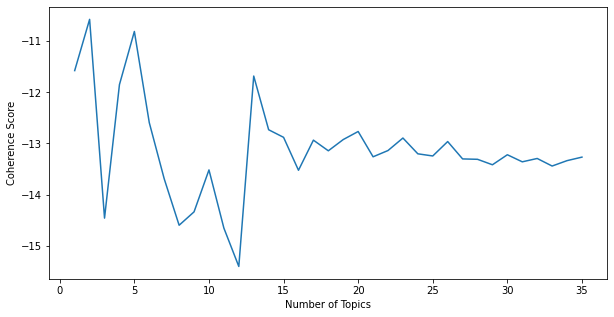

In [33]:
# build a dictionary where for each tweet, each word has its own id.
# We have 6882 tweets and 10893 words in the dictionary.
tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]

# compute coherence
tweets_coherence = []
for nb_topics in range(1,36):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,36),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

testing the lda-model with `num_topics=10` to test our hypothesis

In [38]:
k = 10
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary, passes=10)

topics = tweets_lda.show_topics()

print(len(topics))

10
